Purpose: Figure out code for dimensional reduction pre-random forest.<br>
Author: Anna Pardo<br>
Date initiated: July 7, 2023

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn import metrics
from scipy.spatial.distance import cdist

In [2]:
# load TPM data
tpm = pd.read_csv("../../data/rawtpm_bptreat_noPEG.tsv",sep="\t",header="infer")
tpm.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,SRR11933261,PRJNA637522,Drought,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,...,0.171184,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000
1,SRR11933272,PRJNA637522,Drought,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,...,0.108052,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000
2,SRR11933250,PRJNA637522,Drought,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349
3,SRR11933029,PRJNA637522,Control,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075
4,SRR11933040,PRJNA637522,Drought,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,...,0.178304,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959


In [6]:
# start with k-means clustering
## use silhouette score to find optimum k
# examine silhouette scores of n=2-20 clusters to pick the best n
silhouette_scores = []
n_cluster_list = np.arange(2,21).astype(int)

In [4]:
tpmgene = tpm.set_index("Sample").drop(["BioProject","Treatment"],axis=1).transpose()
tpmgene.head()

Sample,SRR11933261,SRR11933272,SRR11933250,SRR11933029,SRR11933040,SRR11932822,SRR11932811,SRR11933230,SRR11932879,SRR11933475,...,Ms71D3C,Ki3D1C,CML228D1D,CML333D3D,MO18WD3C,B73D3C,NC358D3C,P39D3D,M162WD3D,M162WD1D
Zm00001eb000010,12.553818,16.255838,9.028815,8.201340,10.371251,37.430009,39.925873,30.677016,23.393003,15.222661,...,1.417104,1.923525,1.427602,9.580153,1.228100,2.966207,1.791556,4.286976,3.435711,3.498243
Zm00001eb000020,2.321077,3.110372,2.984479,2.385748,2.799099,27.508819,22.440680,24.648455,7.595576,3.913437,...,0.000000,1.799671,0.000000,0.000000,1.925157,0.561768,0.176413,0.781353,0.379497,0.463832
Zm00001eb000050,0.042520,0.405226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.304751,0.334832,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Zm00001eb000060,12.932676,7.214039,3.092442,1.726808,1.280629,29.510498,22.148225,22.170584,14.727189,13.907885,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Zm00001eb000070,5.253755,1.902461,2.586555,1.926412,3.771234,7.005587,7.590336,5.274585,2.177748,1.810991,...,0.000000,0.451827,0.000000,1.018369,0.000000,0.000000,0.000000,0.000000,1.660372,0.748587


In [5]:
# set X
X = tpmgene.values.copy()

In [6]:
# Very important to scale!
sc = MinMaxScaler()
X = sc.fit_transform(X)

In [30]:
for n_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan2

In [31]:
# bind into a dataframe
ncsil = pd.DataFrame(list(zip(list(n_cluster_list),silhouette_scores)),columns=["Number of clusters","Average silhouette score"])

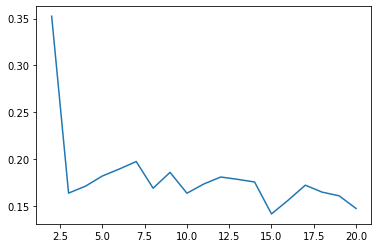

In [32]:
# plot
plt.plot(ncsil["Number of clusters"],ncsil["Average silhouette score"])

In [33]:
# it's probably inadvisable, but I'm going to try k=7
# that's what Jeremy said he did
kmeans = KMeans(n_clusters=7)

In [41]:
cluster_found = kmeans.fit_predict(X)

/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [35]:
cluster_found_sr = pd.Series(cluster_found, name='cluster')

In [45]:
tpm_kmeans = tpmgene.set_index(cluster_found_sr, append=True )
tpm_kmeans.head()

,Sample,SRR11933261,SRR11933272,SRR11933250,SRR11933029,SRR11933040,SRR11932822,SRR11932811,SRR11933230,SRR11932879,SRR11933475,...,Ms71D3C,Ki3D1C,CML228D1D,CML333D3D,MO18WD3C,B73D3C,NC358D3C,P39D3D,M162WD3D,M162WD1D
,cluster,,,,,,,,,,,,,,,,,,,,,
Zm00001eb000010,0,12.553818,16.255838,9.028815,8.201340,10.371251,37.430009,39.925873,30.677016,23.393003,15.222661,...,1.417104,1.923525,1.427602,9.580153,1.228100,2.966207,1.791556,4.286976,3.435711,3.498243
Zm00001eb000020,0,2.321077,3.110372,2.984479,2.385748,2.799099,27.508819,22.440680,24.648455,7.595576,3.913437,...,0.000000,1.799671,0.000000,0.000000,1.925157,0.561768,0.176413,0.781353,0.379497,0.463832
Zm00001eb000050,0,0.042520,0.405226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.304751,0.334832,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Zm00001eb000060,0,12.932676,7.214039,3.092442,1.726808,1.280629,29.510498,22.148225,22.170584,14.727189,13.907885,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Zm00001eb000070,0,5.253755,1.902461,2.586555,1.926412,3.771234,7.005587,7.590336,5.274585,2.177748,1.810991,...,0.000000,0.451827,0.000000,1.018369,0.000000,0.000000,0.000000,0.000000,1.660372,0.748587


In [46]:
# for ease of use later, pull out a dictionary with the list of genes in each cluster
## first pop out the indices as columns
tpm_kmeans = tpm_kmeans.reset_index().rename(columns={"level_0":"GeneID"})
tpm_kmeans.head()

Sample,GeneID,cluster,SRR11933261,SRR11933272,SRR11933250,SRR11933029,SRR11933040,SRR11932822,SRR11932811,SRR11933230,...,Ms71D3C,Ki3D1C,CML228D1D,CML333D3D,MO18WD3C,B73D3C,NC358D3C,P39D3D,M162WD3D,M162WD1D
0,Zm00001eb000010,0,12.553818,16.255838,9.028815,8.201340,10.371251,37.430009,39.925873,30.677016,...,1.417104,1.923525,1.427602,9.580153,1.228100,2.966207,1.791556,4.286976,3.435711,3.498243
1,Zm00001eb000020,0,2.321077,3.110372,2.984479,2.385748,2.799099,27.508819,22.440680,24.648455,...,0.000000,1.799671,0.000000,0.000000,1.925157,0.561768,0.176413,0.781353,0.379497,0.463832
2,Zm00001eb000050,0,0.042520,0.405226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Zm00001eb000060,0,12.932676,7.214039,3.092442,1.726808,1.280629,29.510498,22.148225,22.170584,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Zm00001eb000070,0,5.253755,1.902461,2.586555,1.926412,3.771234,7.005587,7.590336,5.274585,...,0.000000,0.451827,0.000000,1.018369,0.000000,0.000000,0.000000,0.000000,1.660372,0.748587


In [48]:
# now generate dictionary
genes_in_clusters = {}
for c in tpm_kmeans["cluster"].unique():
    df = tpm_kmeans[tpm_kmeans["cluster"]==c]
    genes_in_clusters[c] = df["GeneID"].unique()

In [52]:
# how many genes in each cluster?
for c in genes_in_clusters.keys():
    print("Cluster "+str(c)+" contains "+str(len(genes_in_clusters.get(c)))+" genes")

Cluster 0 contains 38429 genes
Cluster 4 contains 153 genes
Cluster 1 contains 35 genes
Cluster 6 contains 376 genes
Cluster 3 contains 3 genes
Cluster 5 contains 6 genes
Cluster 2 contains 2 genes


In [7]:
# this seems...less than optimal
# going to try the elbow method
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(2, 31)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan2

/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan2

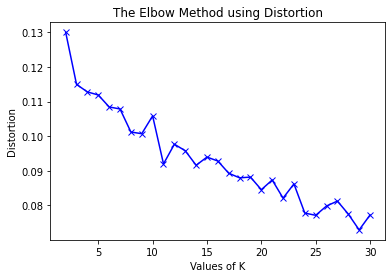

In [8]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

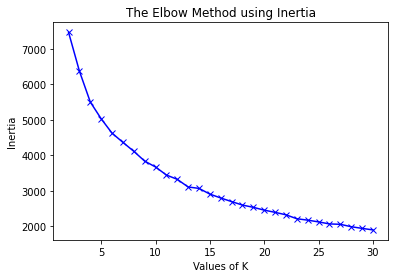

In [9]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

With the distortion method, there is no clear optimal value of k, whereas with the elbow method, it appears to be about 14. So I will try with k=14.

In [10]:
kmeans = KMeans(n_clusters=14)

In [11]:
cluster_found = kmeans.fit_predict(X)

/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [12]:
cluster_found_sr = pd.Series(cluster_found, name='cluster')

In [14]:
tpm_kmeans = tpmgene.set_index(cluster_found_sr, append=True )
tpm_kmeans.head()

,Sample,SRR11933261,SRR11933272,SRR11933250,SRR11933029,SRR11933040,SRR11932822,SRR11932811,SRR11933230,SRR11932879,SRR11933475,...,Ms71D3C,Ki3D1C,CML228D1D,CML333D3D,MO18WD3C,B73D3C,NC358D3C,P39D3D,M162WD3D,M162WD1D
,cluster,,,,,,,,,,,,,,,,,,,,,
Zm00001eb000010,0,12.553818,16.255838,9.028815,8.201340,10.371251,37.430009,39.925873,30.677016,23.393003,15.222661,...,1.417104,1.923525,1.427602,9.580153,1.228100,2.966207,1.791556,4.286976,3.435711,3.498243
Zm00001eb000020,0,2.321077,3.110372,2.984479,2.385748,2.799099,27.508819,22.440680,24.648455,7.595576,3.913437,...,0.000000,1.799671,0.000000,0.000000,1.925157,0.561768,0.176413,0.781353,0.379497,0.463832
Zm00001eb000050,0,0.042520,0.405226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.304751,0.334832,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Zm00001eb000060,0,12.932676,7.214039,3.092442,1.726808,1.280629,29.510498,22.148225,22.170584,14.727189,13.907885,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Zm00001eb000070,0,5.253755,1.902461,2.586555,1.926412,3.771234,7.005587,7.590336,5.274585,2.177748,1.810991,...,0.000000,0.451827,0.000000,1.018369,0.000000,0.000000,0.000000,0.000000,1.660372,0.748587


In [15]:
tpm_kmeans = tpm_kmeans.reset_index().rename(columns={"level_0":"GeneID"})
tpm_kmeans.head()

Sample,GeneID,cluster,SRR11933261,SRR11933272,SRR11933250,SRR11933029,SRR11933040,SRR11932822,SRR11932811,SRR11933230,...,Ms71D3C,Ki3D1C,CML228D1D,CML333D3D,MO18WD3C,B73D3C,NC358D3C,P39D3D,M162WD3D,M162WD1D
0,Zm00001eb000010,0,12.553818,16.255838,9.028815,8.201340,10.371251,37.430009,39.925873,30.677016,...,1.417104,1.923525,1.427602,9.580153,1.228100,2.966207,1.791556,4.286976,3.435711,3.498243
1,Zm00001eb000020,0,2.321077,3.110372,2.984479,2.385748,2.799099,27.508819,22.440680,24.648455,...,0.000000,1.799671,0.000000,0.000000,1.925157,0.561768,0.176413,0.781353,0.379497,0.463832
2,Zm00001eb000050,0,0.042520,0.405226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Zm00001eb000060,0,12.932676,7.214039,3.092442,1.726808,1.280629,29.510498,22.148225,22.170584,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Zm00001eb000070,0,5.253755,1.902461,2.586555,1.926412,3.771234,7.005587,7.590336,5.274585,...,0.000000,0.451827,0.000000,1.018369,0.000000,0.000000,0.000000,0.000000,1.660372,0.748587


In [16]:
genes_in_clusters = {}
for c in tpm_kmeans["cluster"].unique():
    df = tpm_kmeans[tpm_kmeans["cluster"]==c]
    genes_in_clusters[c] = df["GeneID"].unique()

In [17]:
# how many genes in each cluster?
for c in genes_in_clusters.keys():
    print("Cluster "+str(c)+" contains "+str(len(genes_in_clusters.get(c)))+" genes")

Cluster 0 contains 37655 genes
Cluster 8 contains 904 genes
Cluster 6 contains 160 genes
Cluster 2 contains 38 genes
Cluster 4 contains 170 genes
Cluster 13 contains 51 genes
Cluster 3 contains 12 genes
Cluster 10 contains 1 genes
Cluster 1 contains 5 genes
Cluster 7 contains 1 genes
Cluster 12 contains 2 genes
Cluster 5 contains 1 genes
Cluster 9 contains 2 genes
Cluster 11 contains 2 genes


It doesn't seem better. I'm not sure if this is normal or what.